# 5.  Análisis por objetivos (Objetivo Específico 2)

Análisis Territorial y de Segmentación (Objetivo Específico 2): Identificar patrones y brechas territoriales en los indicadores educativos mediante técnicas de análisis exploratorio y segmentación, como el clustering.

## 5.1 Configuración del Entorno e Importación de Módulos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os
  
# Añadir la carpeta 'src' y 'config' al path de Python,
sys.path.append(os.path.abspath(os.path.join('..', 'src'))),
sys.path.append(os.path.abspath(os.path.join('..', 'config'))),

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Importar funciones y variables desde tus módulos,
from data_loader import load_data # Para cargar los datos ya limpios,
# Importar funciones de visualización,
from visualizer import(
    plot_kmeans_elbow,
    view_clusters_pca,
    plot_cluster_bar_charts,
    plot_cluster_box_plots
) 
from utils import (
    apply_kmeans_clustering
)
from statistical_analysis import(
    perform_cluster_anova
)
from settings import (
    PROCESSED_DATA_PATH, 
    INDICADORES_CLAVES_TASAS,
    INDICADORES_PRINCIPALES_VIZ,
    FIGURES_PATH,
    INDICADORES_BOXPLOTS
   
)

## 5.2 Carga del Dataset Limpio

In [2]:
# Cargar el dataset limpio 
df_cleaned = load_processed_data(PROCESSED_DATA_PATH)

if df_cleaned is not None:
    print("✅ Datos limpios cargados exitosamente.\n")
    print(df_cleaned.head())
    print(f"Dimensiones del DataFrame limpio: {df_cleaned.shape}")
else:
    print("⛔ No se pudo cargar el DataFrame limpio.")

Intentando cargar los datos procesados desde: c:\Users\LENOVO\OneDrive\Documentos\python class\Dathon_Academic_MEN\data\processed\datos_educacion_limpios.csv
Datos procesados cargados exitosamente. Dimensiones: (14582, 34)
✅ Datos limpios cargados exitosamente.

   Unnamed: 0  anio  codigo_municipio   municipio  codigo_departamento  \
0           0  2023              5001    Medellín                    5   
1           1  2023              5002   Abejorral                    5   
2           2  2023              5004    Abriaquí                    5   
3           3  2023              5021  Alejandría                    5   
4           4  2023              5030       Amagá                    5   

  departamento  codigo_etc              etc  poblacion_5_16  \
0    Antioquia      3759.0         Medellín        377562.0   
1    Antioquia      3758.0  Antioquia (ETC)          3634.0   
2    Antioquia      3758.0  Antioquia (ETC)           503.0   
3    Antioquia      3758.0  Antioquia (E

### 5.3 Preparación de los datos para el clustering

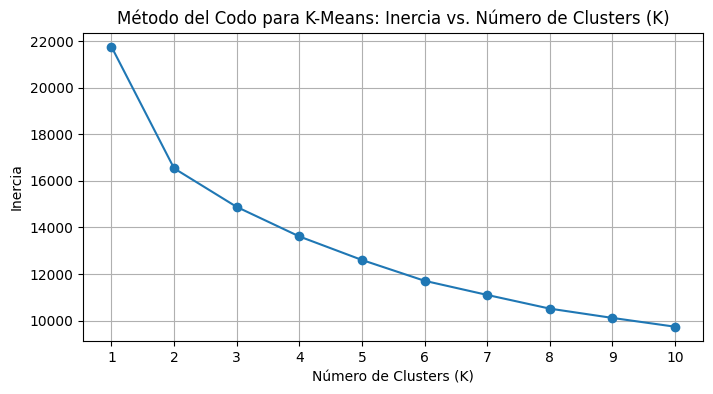

In [3]:
# Definir las características que se usarán para el clustering, incluyendo poblacion_5_16
features_for_clustering = INDICADORES_CLAVES_TASAS + ['poblacion_5_16']

#Agrupa y resume datos numéricos por municipio
df_cluster_data = df_cleaned.groupby('municipio')[features_for_clustering].mean().dropna()

#Estandarizar
scaler = StandardScaler()
df_scaled_array = scaler.fit_transform(df_cluster_data)

# Convertir el array de nuevo a DataFrame, conservando los índices y columnas originales
df_scaled = pd.DataFrame(df_scaled_array, index=df_cluster_data.index, columns=df_cluster_data.columns)

plot_kmeans_elbow(df_scaled)


Se aplica el método del codo para K-Means con el fin de determinar el número óptimo de clusters en este caso, se produce el "codo" en 4.

### 5.4 Aplicar K-Means con el número óptimo de clusters (basado en el codo, usamos 4)

In [4]:
df_clustesr, labels = apply_kmeans_clustering(df_cluster_data, df_scaled, optimal_k=4)


Número óptimo de clusters elegido (según Método del Codo): 4

✅ Clustering K-Means completado y etiquetas asignadas a 4 clusters.
Conteo de municipios por cluster:
 Cluster
3    371
0    275
2    253
1    137
Name: count, dtype: int64


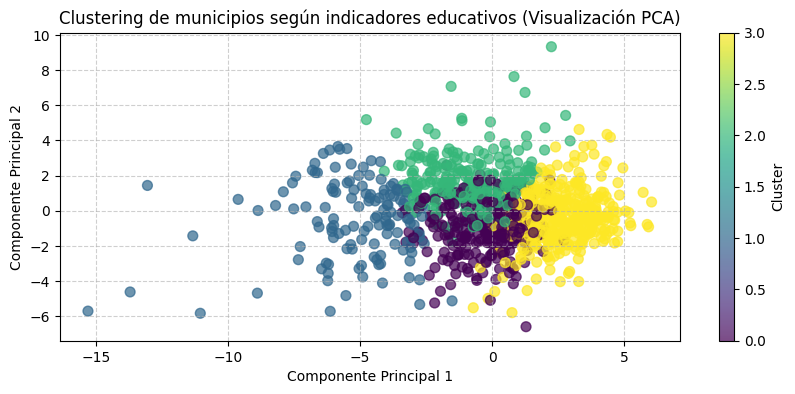


Visualización PCA de los clusters generada.


In [5]:
view_clusters_pca(
    df_scaled, 
    etiquetas_cluster=df_clustesr['Cluster'],
    titulo="Clustering de municipios según indicadores educativos (Visualización PCA)"
    )

🔍 Observaciones sobre el clustering

Se formaron 4 grupos de municipios (clusters), cada uno con características educativas parecidas.

**Cluster amarillo (grupo 3):** Está bien separado del resto.
Probablemente representa municipios con mejores condiciones educativas (alta cobertura, baja deserción, buen rendimiento).

**Cluster azul (grupo 1):** Es el más disperso.
Podría incluir municipios con mayores dificultades educativas.

**Clusters verde (2) y morado (0):** Están más mezclados.
Representan municipios con condiciones intermedias o diversas en términos de educación.


--- Perfiles Promedio de los Clusters (Valores sin escalar) ---
         cobertura_neta  cobertura_neta_primaria  cobertura_neta_secundaria  \
Cluster                                                                       
0                 83.47                    81.24                      63.75   
1                 80.61                    79.84                      58.19   
2                 91.73                    88.24                      79.74   
3                 85.21                    81.19                      72.72   

         cobertura_neta_media  desercion  desercion_primaria  \
Cluster                                                        
0                       34.46       4.25                3.48   
1                       28.89       5.17                4.20   
2                       48.61       3.25                2.50   
3                       44.97       2.48                2.00   

         desercion_secundaria  desercion_media  aprobacion  \
Cluster      

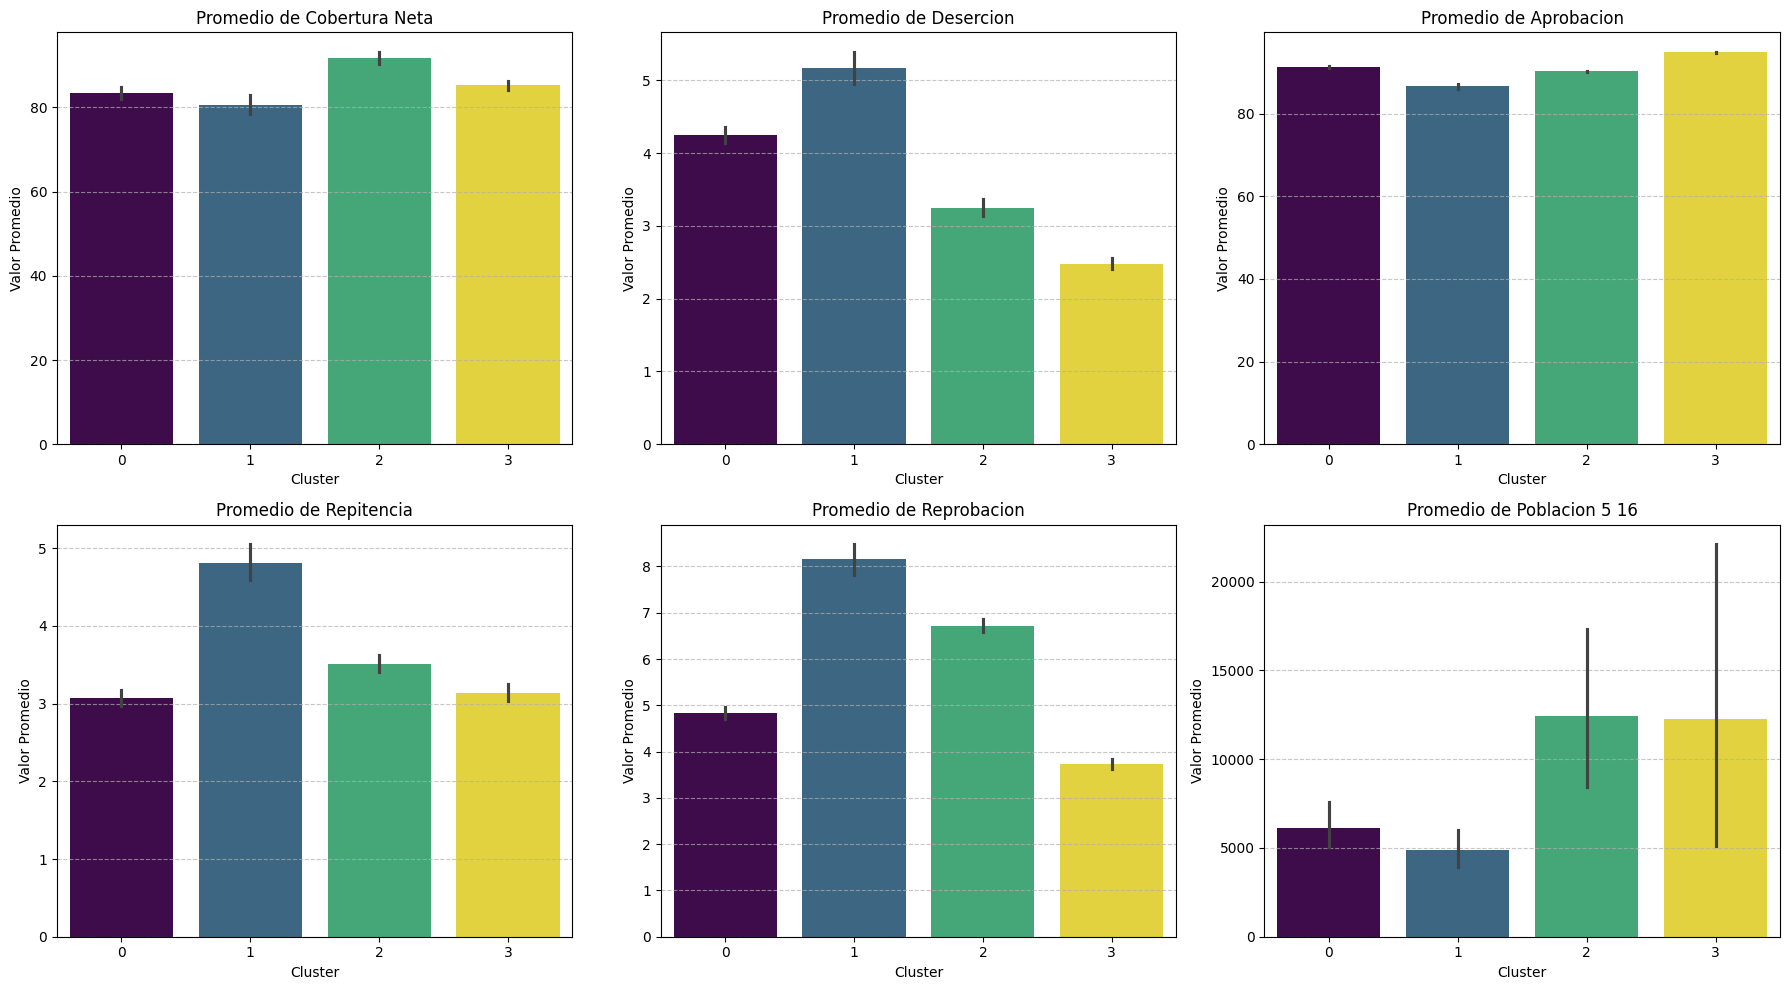


✅ Gráfico de barras de promedios por cluster generado.

--- Boxplots para Distribución de Indicadores por Cluster ---
✅ Gráfico de boxplots de clusters guardado en: c:\Users\LENOVO\OneDrive\Documentos\python class\Dathon_Academic_MEN\reports\figuras\cluster_box_plots.png


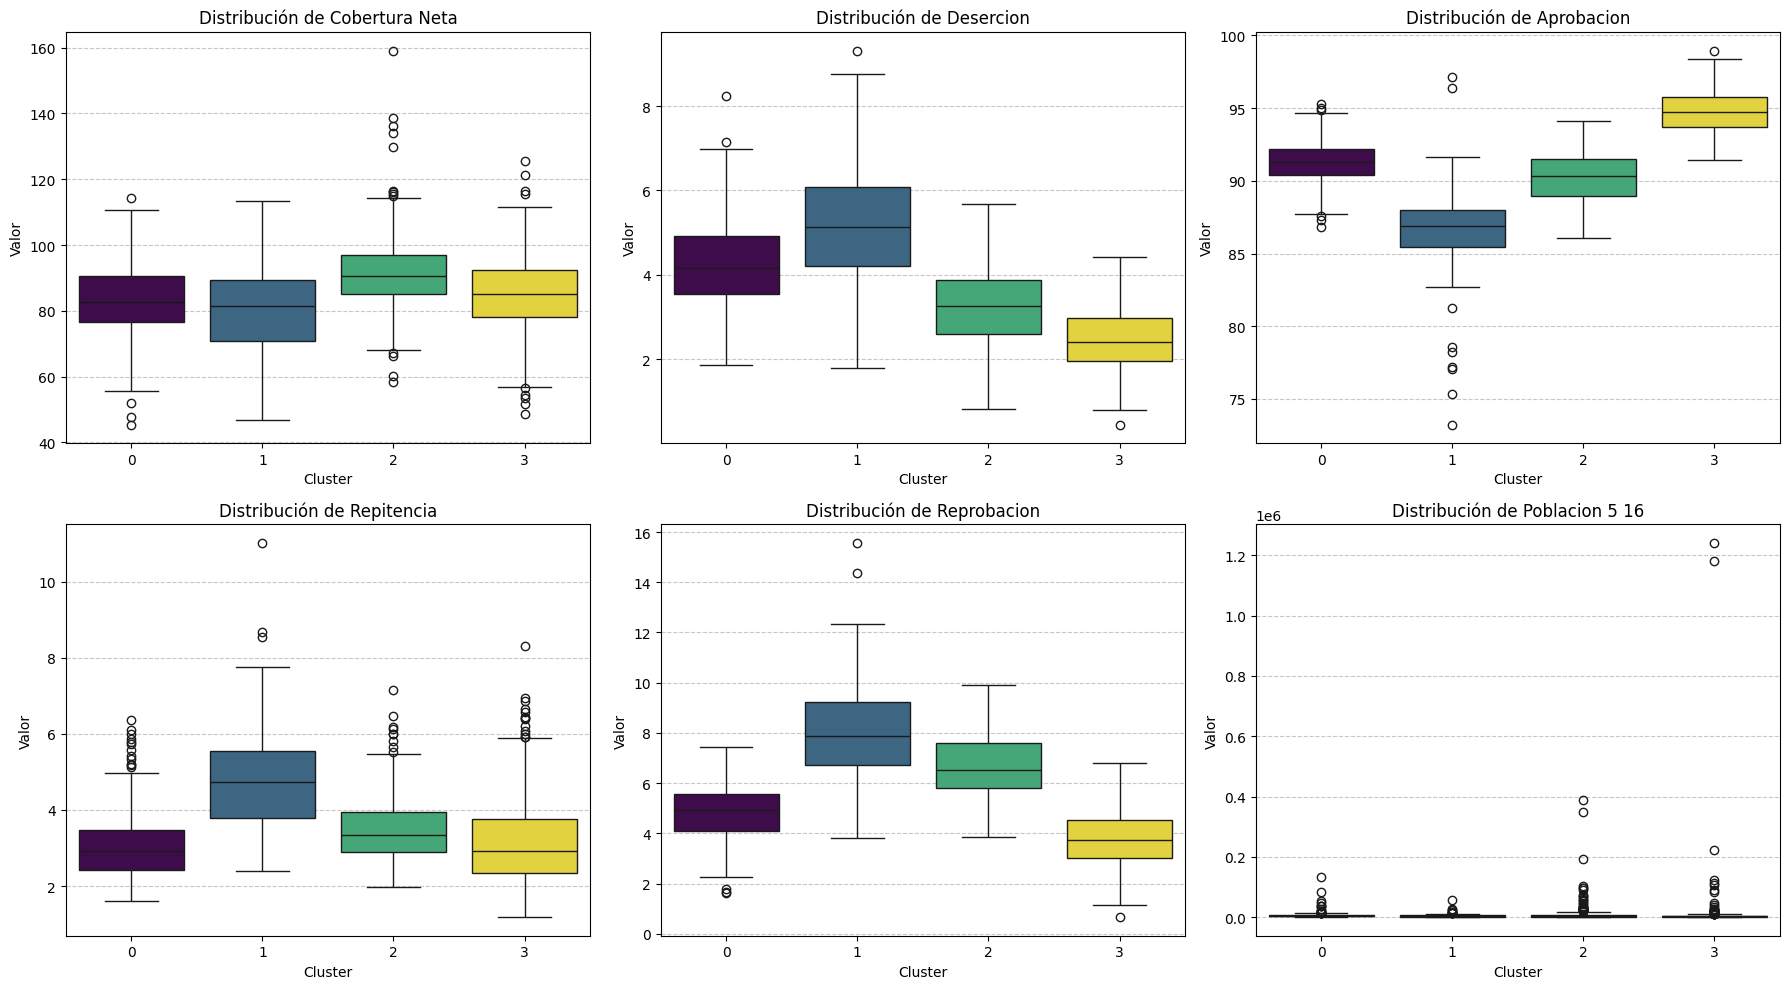


✅ Gráfico de boxplots de distribución por cluster generado.


In [6]:
# 1. Caracterización Numérica: Promedios y Medianas por Cluster
print("\n--- Perfiles Promedio de los Clusters (Valores sin escalar) ---")
cluster_means = df_clustesr.groupby('Cluster')[features_for_clustering].mean()
print(cluster_means.round(2))

print("\n--- Perfiles Mediana de los Clusters (Valores sin escalar) ---")
cluster_medians = df_clustesr.groupby('Cluster')[features_for_clustering].median()
print(cluster_medians.round(2))

# 2. Gráficos de Barras organizados en subplots (filas de 3)
plot_cluster_bar_charts(
    df_clustesr, 
    INDICADORES_PRINCIPALES_VIZ, 
    title_prefix="Promedios por Cluster (Gráficos de Barras)", 
    save_dir=FIGURES_PATH
)

plot_cluster_box_plots(
    df_clustesr, 
    INDICADORES_PRINCIPALES_VIZ, 
    title_prefix="Boxplots para Distribución de Indicadores por Cluster", 
    save_dir=FIGURES_PATH
)

In [7]:
# Ejecutar la función ANOVA
anova_results_df = perform_cluster_anova(
        df_clustered=df_clustesr,
        indicators_list=INDICADORES_BOXPLOTS,
        cluster_col='Cluster',
        alpha=0.05
)

if anova_results_df is not None:
    print("\n--- Resumen de Resultados ANOVA ---")
    print(anova_results_df.to_string())
else:
    print("\nNo se generaron resultados ANOVA.")


--- INICIANDO ANÁLISIS ANOVA PARA VALIDAR BRECHAS ENTRE CLUSTERS ---

--- Resultados ANOVA para: Cobertura Neta ---
  Estadístico F: 34.036
  P-valor: 0.00000
  **Conclusión:** Con un P-valor de 0.00000 (que es menor que 0.05),
  RECHAZAMOS la hipótesis nula (H0). Existen diferencias estadísticamente significativas.
  Esto respalda fuertemente la existencia de brechas territoriales en cobertura neta.

--- Resultados ANOVA para: Desercion ---
  Estadístico F: 344.519
  P-valor: 0.00000
  **Conclusión:** Con un P-valor de 0.00000 (que es menor que 0.05),
  RECHAZAMOS la hipótesis nula (H0). Existen diferencias estadísticamente significativas.
  Esto respalda fuertemente la existencia de brechas territoriales en desercion.

--- Resultados ANOVA para: Aprobacion ---
  Estadístico F: 792.859
  P-valor: 0.00000
  **Conclusión:** Con un P-valor de 0.00000 (que es menor que 0.05),
  RECHAZAMOS la hipótesis nula (H0). Existen diferencias estadísticamente significativas.
  Esto respalda fuertem